# I. Preparation

In [1]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import transforms
import matplotlib.pyplot as plt

from nn_interpretability.model.model_trainer import ModelTrainer
from nn_interpretability.model.model_repository import ModelRepository
from nn_interpretability.visualization.mnist_visualizer import MnistVisualizer
from nn_interpretability.dataset.mnist_data_loader import MnistDataLoader
from nn_interpretability.interpretation.occlusion_sensitivity.occlusion_sensitivity import OcclusionSensitivity
from nn_interpretability.interpretation.deeplift.deeplift import DeepLIFT, DeepLIFTRules

In [2]:
mnist_data_loader = MnistDataLoader()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

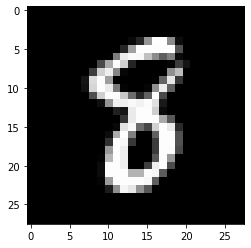

In [3]:
MnistVisualizer.show_dataset_examples(mnist_data_loader.trainloader)

# II. Occlusion Sensitivity

Occlusion Sensitivity is a decision-based intepretability method which obstructs parts of the input in order to see what influence these regions have to the output of the model under test.

In [4]:
model_name = 'model_cnn.pt'
train = False
model = ModelRepository.get_general_mnist_cnn(model_name)

if train:
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0005)

    model.train()
    ModelTrainer.train(model, criterion, optimizer, mnist_data_loader.trainloader, 1)
    
    ModelRepository.save(model, model_name)

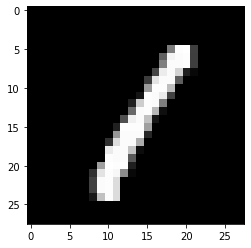

In [5]:
label = 1
img = mnist_data_loader.get_image_for_class(label).cpu()
MnistVisualizer.show(img)

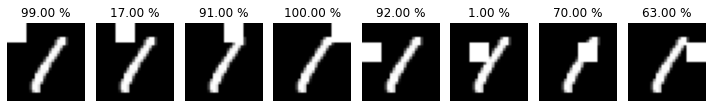

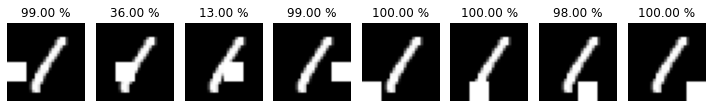

In [6]:
input_size = (28, 28)
block_size = (7, 7)
fill_value = 1

interpretor = OcclusionSensitivity(model, None, None, input_size, block_size, fill_value, label)
images, probabilities = interpretor.interpret(img)

MnistVisualizer.display_images_with_probability(images[:8], probabilities[:8], 10, 10)
MnistVisualizer.display_images_with_probability(images[8:], probabilities[8:], 10, 10)

# III. Occlusion Sensitivity & DeepLIFT

Occlusion Sensitivity can be successfully applied in combinaction with other decision-based interpretability methods. In this example, we consider the combination of Occlusion Sensitivity and DeepLIFT. In the first case, we will run DeepLIFT on the initial image. After that, we will execute DeepLIFT on the two occluded inputs which produce the lowest model output out of all images.

## 1.1 DeepLIFT result for original image

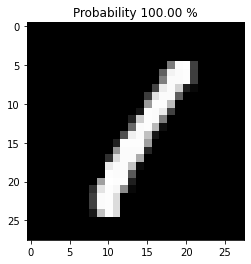

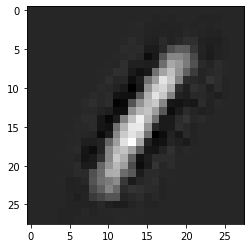

In [7]:
interpreter = DeepLIFT(model, [str(i) for i in range(10)], None, DeepLIFTRules.LinearRevealCancel)

out = interpreter.interpret(img)
interpreter.cleanup()

logits = model(img.to(device)).to(device)
probs = torch.nn.functional.softmax(logits, dim=1).detach().cpu().numpy()[0]
prob = round(probs[label], 2)

MnistVisualizer.show_with_probability(img.detach().cpu().numpy(), prob)
MnistVisualizer.show(out)

## 1.2 DeepLIFT result for the occluded image with worst model output

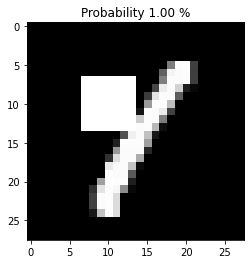

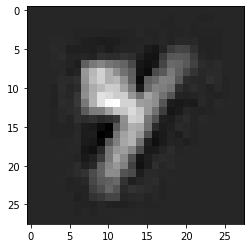

In [8]:
lowest_value_index = probabilities.index(sorted(probabilities)[0])

interpreter = DeepLIFT(model, [str(i) for i in range(10)], None, DeepLIFTRules.LinearRevealCancel)

img = images[lowest_value_index]
out = interpreter.interpret(img)
interpreter.cleanup()

MnistVisualizer.show_with_probability(img.detach().cpu().numpy(), probabilities[lowest_value_index])
MnistVisualizer.show(out)

## 1.3 DeepLIFT result for the occluded image with second worst model output

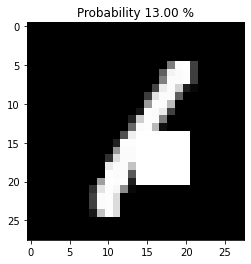

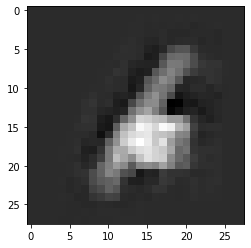

In [9]:
second_lowest_value_index = probabilities.index(sorted(probabilities)[1])

interpreter = DeepLIFT(model, [str(i) for i in range(10)], None, DeepLIFTRules.LinearRevealCancel)

img = images[second_lowest_value_index]
out = interpreter.interpret(img)
interpreter.cleanup()

MnistVisualizer.show_with_probability(img.detach().cpu().numpy(), probabilities[second_lowest_value_index])
MnistVisualizer.show(out)